In [59]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 16, 8

In [60]:
data = pd.read_csv(r"F:\Desktop\Digital Lync\DataSets\Time Series\AirPassengers.csv", index_col = 'Month',
                   parse_dates = ['Month'])

In [61]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [62]:
ts = data['#Passengers']; ts.head()

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

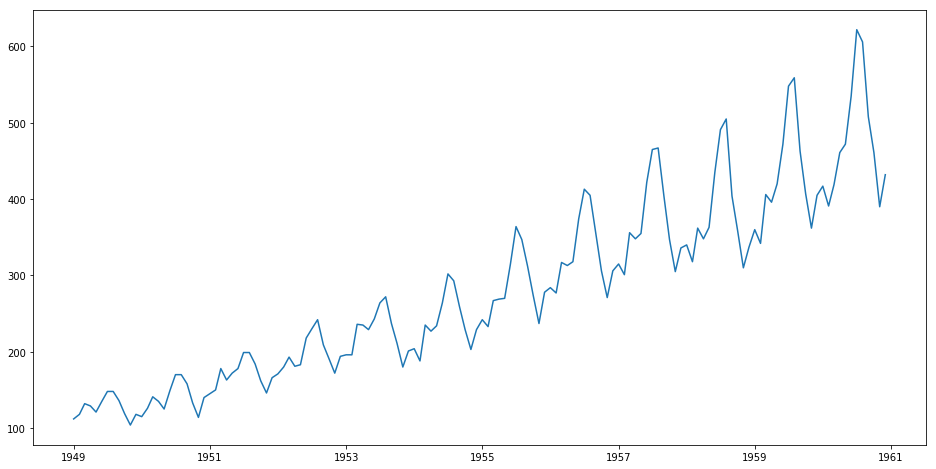

In [63]:
plt.plot(ts)
plt.show()

In [64]:
# Dickey Fuller test for Stationarity


from statsmodels.tsa.stattools import adfuller

def stat(timeser):
    print("Dickey Fuller Test Stats\n")
    dftest = adfuller(timeser, autolag = 'AIC')
    dfop = pd.Series(dftest[0:4], index = ['Test-Stats', 'p-value', 'lags used', 'No.of Observ'])
    for key, value in dftest[4].items():
        dfop['Critical Value %s' %key] = value
    print(dfop)
stat(ts)

Dickey Fuller Test Stats

Test-Stats              0.815369
p-value                 0.991880
lags used              13.000000
No.of Observ          130.000000
Critical Value 1%      -3.481682
Critical Value 5%      -2.884042
Critical Value 10%     -2.578770
dtype: float64


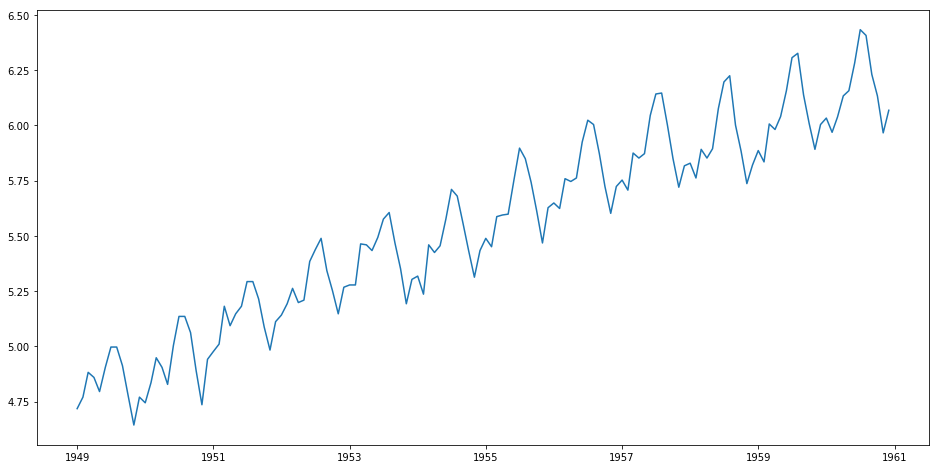

In [69]:
# to remove seasonality we should transform the ts

ts_log = np.log(ts)
plt.plot(ts_log)
plt.show()

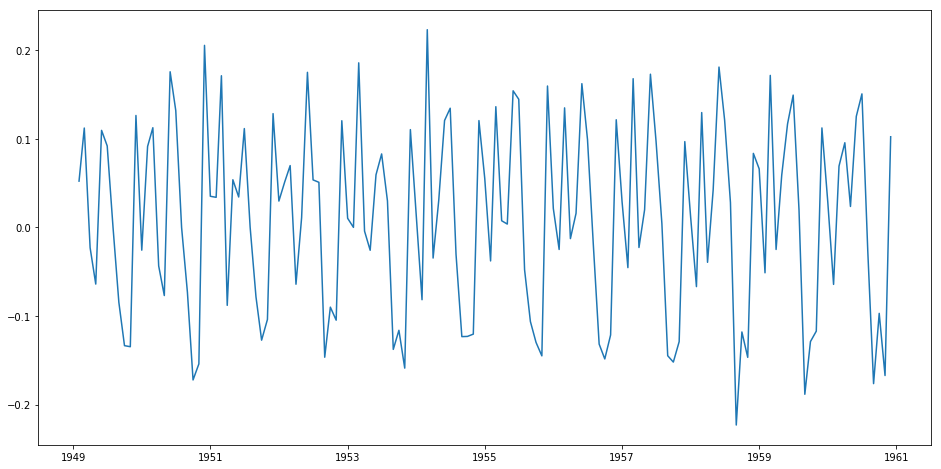

In [72]:
# to remove trend we can use differencing.

ts_log_diff = ts_log - ts_log.shift() # this is differencing
ts_log_diff.dropna(inplace  = True) # dropping the missing values
plt.plot(ts_log_diff)
plt.show()

In [ ]:
# another way to remove trend is Moving Avg's
"""mov_avg = ts_log.rolling(window = 12).mean()
plt.plot(ts_log)
plt.plot(mov_avg, color = 'red')
plt.show()"""


"""ts_log_diff = ts_log - mov_avg
print(ts_log_diff.head(3))
ts_log_diff.dropna(inplace = True)
print(ts_log_diff.head(3))
plt.plot(ts_log_diff)
plt.show()"""

In [73]:
stat(ts_log_diff)

Dickey Fuller Test Stats

Test-Stats             -2.717131
p-value                 0.071121
lags used              14.000000
No.of Observ          128.000000
Critical Value 1%      -3.482501
Critical Value 5%      -2.884398
Critical Value 10%     -2.578960
dtype: float64


In [74]:
# Forcasting Timeseries using acf and pacf plots

from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags = 20)
lag_pacf = pacf(ts_log_diff, nlags = 20)

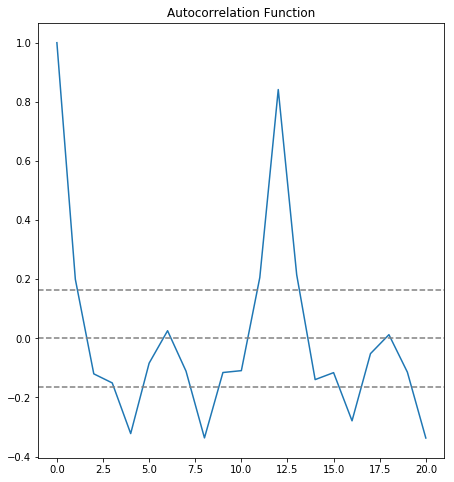

In [75]:
#plot ACF

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

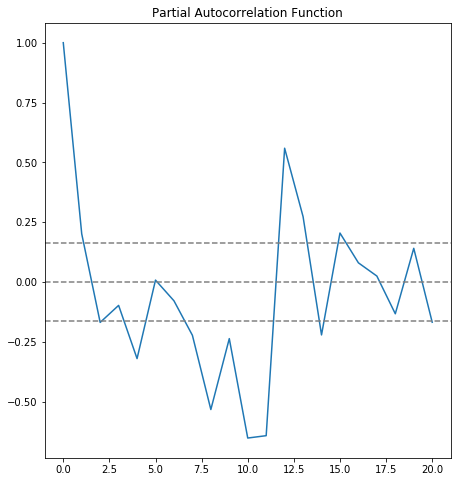

In [76]:
#plot PACF

plt.subplot(121)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

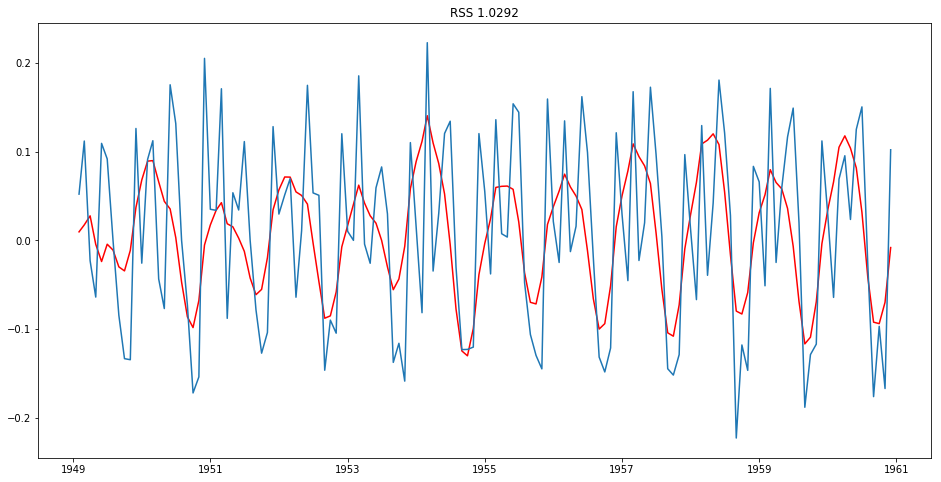

In [77]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(ts_log, order = (2, 1, 2))
result = model.fit(disp = -1)
plt.plot(result.fittedvalues, color = 'red')
plt.plot(ts_log_diff)
plt.title('RSS %.4f' %sum((result.fittedvalues - ts_log_diff) **2))
plt.show()

In [78]:
pred_ARIMA = pd.Series(results.fittedvalues, copy = True)
pred_ARIMA.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

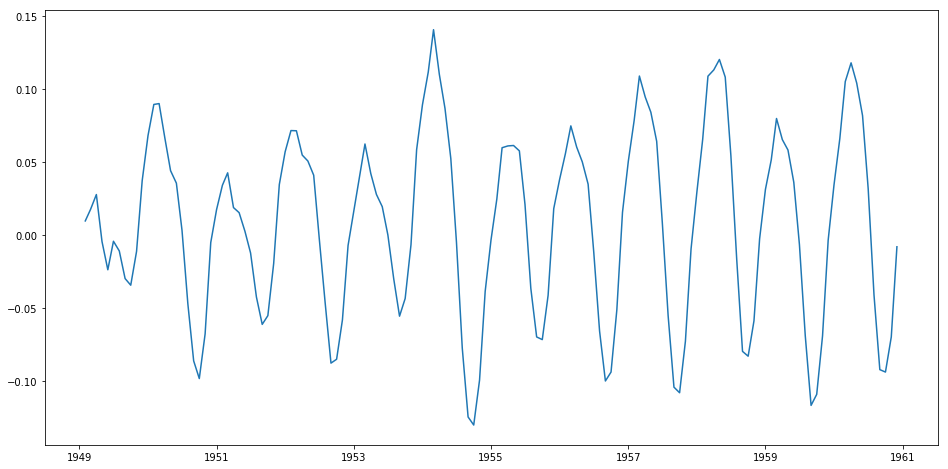

In [79]:
plt.plot(pred_ARIMA)
plt.show()

In [80]:
pred_ARIMA_cumsum = pred_ARIMA.cumsum()
pred_ARIMA_cumsum.head(4)

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
dtype: float64

In [81]:
pred_ARIMA_log = pd.Series(ts_log.iloc[0], index = ts_log.index)
pred_ARIMA_log = pred_ARIMA_log.add(pred_ARIMA_cumsum, fill_value=0)

In [82]:
pred_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

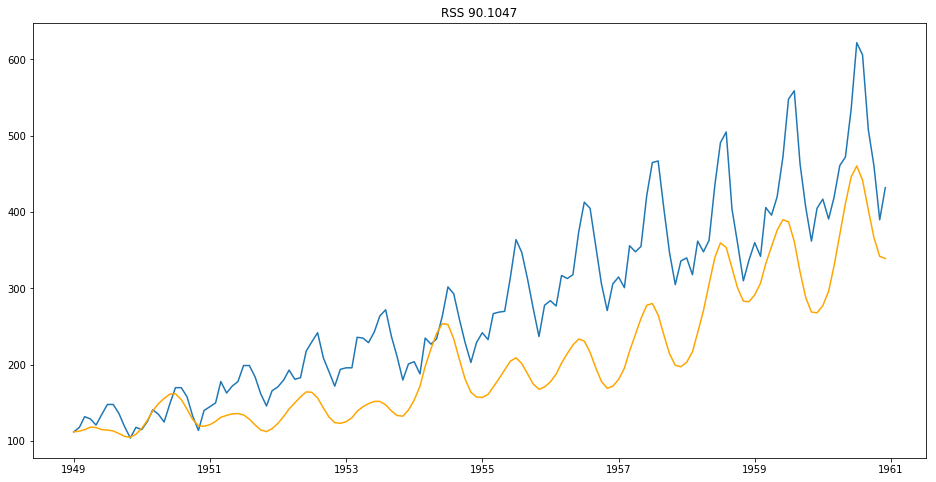

In [85]:
pred = np.exp(pred_ARIMA_log)
plt.plot(ts)
plt.plot(pred, color = 'orange')
plt.title('RSS %.4f' %np.sqrt(sum((pred-ts)**2)/len(ts)))
plt.show()